# **Problema de Negócio**

1.   Análisar o preço do petróleo Brent através de base de dados do site da IPEA
2.   Criar um dashboard que faça parte de um storytelling com insights interessantes
3.   Criar um modelo que faça previsão diária do preço e que contenha um plano de deploy
4.   Fazer o MVP do modelo em produção no streamlit

**Esse notebook vai abordar um pouco das 4 etapas**




### **Início e preparação para os dashs**

#### **Imports importantes e leitura inicial da base**

In [ ]:
!pip install prophet

In [ ]:
import pandas as pd
from datetime import datetime
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  statsmodels.tsa.seasonal import seasonal_decompose
from  statsmodels.tsa.stattools import acf, pacf, adfuller
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from prophet import *

#### **Lendo base e preparando pro Power BI**

In [ ]:
# URL do site Ipeadata
url = "http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view"

# Fazendo a requisição para o site
response = requests.get(url)

# Usando pandas para ler a tabela diretamente do HTML
dfs = pd.read_html(response.text, attrs={'id': 'grd_DXMainTable'})

# Verificar se a tabela foi lida corretamente e limpar os dados
if len(dfs) > 0:
    df = dfs[0]
    df.columns = ['Data', 'Preco']

    # Salvando os dados em um arquivo CSV
    df.to_csv('preco_petroleo_brent_atualizado.csv', index=False, encoding='utf-8')
    df = pd.read_csv('preco_petroleo_brent_atualizado.csv')
    print(df.head())
    print("Dados salvos com sucesso no arquivo 'preco_petroleo_brent_atualizado.csv'")
else:
    print("Nenhuma tabela encontrada.")

         Data                                 Preco
0        Data  Preço - petróleo bruto - Brent (FOB)
1  15/04/2024                                  9084
2  12/04/2024                                  9312
3  11/04/2024                                  9149
4  10/04/2024                                  9157
Dados salvos com sucesso no arquivo 'preco_petroleo_brent_atualizado.csv'


#### **Tratando a base para o Power BI**

In [ ]:
#Removendo a primeira linha
df = df.drop(0)

# Convertendo a coluna 'Data' para datetime
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
df = df.reset_index(drop=True).sort_values(by="Data", ascending=False)

# Transformando a coluna 'Preço' em float e ajustando a escala
df['Preco'] = df['Preco'].astype(int) / 100

# Adicionando colunas que facilitarão a criação de dashboards
base_bi = df.copy()
base_bi['Mes'] = base_bi['Data'].dt.month
base_bi['Ano'] = base_bi['Data'].dt.year
base_bi = base_bi[['Data', 'Mes', 'Ano', 'Preco']]

##### **Escolhendo Eventos que farão partes dos insights nos dashs**

In [ ]:
# Definindo eventos importantes para o preço do petróleo
dicionario_eventos = {
    (1973, 1974): 'Embargo do Petróleo',
    (1979, 1981): 'Revolução Iraniana',
    (1980, 1988): 'Guerra Irã-Iraque',
    1990: 'Guerra do Golfo',
    1997: 'Crise Financeira Asiática',
    2003: 'Guerra do Iraque',
    2008: 'Crise Financeira Global',
    (2014, 2015): 'Queda Multi-Fator',
    (2020, 2021): 'Pandemia de COVID-19',
}

def aplicando_eventos(row):
    for anos, eventos in dicionario_eventos.items():
        # Verifica se o ano está dentro de algum intervalo ou é um ano específico
        if isinstance(anos, tuple):
            if row['Ano'] >= anos[0] and row['Ano'] <= anos[1]:
                return eventos
        elif row['Ano'] == anos:
            return eventos
    return 'Sem Eventos Globais'

# Aplica a função atualizada para criar a coluna 'Eventos'
base_bi['Eventos'] = base_bi.apply(aplicando_eventos, axis=1)
base_bi.head()  # Exibe as primeiras linhas para verificação

,Data,Mes,Ano,Preco,Eventos
0,2024-04-15,4,2024,90.84,Sem Eventos Globais
1,2024-04-12,4,2024,93.12,Sem Eventos Globais
2,2024-04-11,4,2024,91.49,Sem Eventos Globais
3,2024-04-10,4,2024,91.57,Sem Eventos Globais
4,2024-04-09,4,2024,92.13,Sem Eventos Globais


In [ ]:
#Salvando base que os dashs irão consumir
from google.colab import files
base_bi.to_csv('base_preco_petroleo.csv', index=False)
files.download('base_preco_petroleo.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Análise Exploratória**

##### **Funções úteis**

In [ ]:
#Funções desenvolvidas em challenges anteriores para melhor análise da base

def teste_adf(serie_temporal):
    """
    Executa o teste Augmented Dickey-Fuller (ADF) em uma série temporal passada como argumento.

    Args:
    serie_temporal (pandas.Series): Série temporal onde será realizado o teste ADF.

    O output da função são os resultados do teste ADF.
    """

    # Executa o teste ADF na série fornecida
    result = adfuller(serie_temporal)

    # Imprime os resultados do teste ADF
    print("Teste ADF")
    print(f"Teste Estatístico: {result[0]}")
    print(f"P-Value: {result[1]}")
    print("Valores críticos:")
    for key, value in result[4].items():
        print(f"{key}: {value}")

def plot_graficos(serie_temporal, media_movel=None, desvio_padrao=None):
    """
    Tem como fução plota um gráfico de uma série temporal. Podemos incluir a média móvel e o desvio padrão caso necessário.

    Args:
    serie_temporal (pandas.Series): A série temporal que iremos plotar.
    media_movel (pandas.Series, opcional): Média Móvel.
    desvio_padrao (pandas.Series, opcional): Desvio Padrão.

    A função cria um gráfico da série principal e, opcionalmente, das séries de média móvel e desvio padrão móvel, se fornecidas.
    """


    # Cria uma figura e um eixo para plotagem
    f, ax = plt.subplots(figsize=(12, 5))

    # Plota a série principal no eixo
    serie_temporal.plot(ax=ax, legend=False, xlabel='')

    # Se uma série de média móvel é fornecida, plota isso também
    if media_movel is not None:
        media_movel.plot(ax=ax, legend=False, color='r', xlabel='')

    # Se uma série de desvio padrão é fornecida, plota isso também
    if desvio_padrao is not None:
        desvio_padrao.plot(ax=ax, legend=False, color='g', xlabel='')

    # Ajusta o layout do gráfico para evitar sobreposição de elementos
    plt.tight_layout()

##### **Tratamento e visão inicial**

In [ ]:
#Renomeando colunas para os nomes ideais para modelagem
df = df.rename(columns= {'Data':'ds', 'Preco': 'y'})

#Selecionando colunas desejadas e transformando data em índice
df = df[['ds', 'y']]
df.set_index('ds', inplace=True )

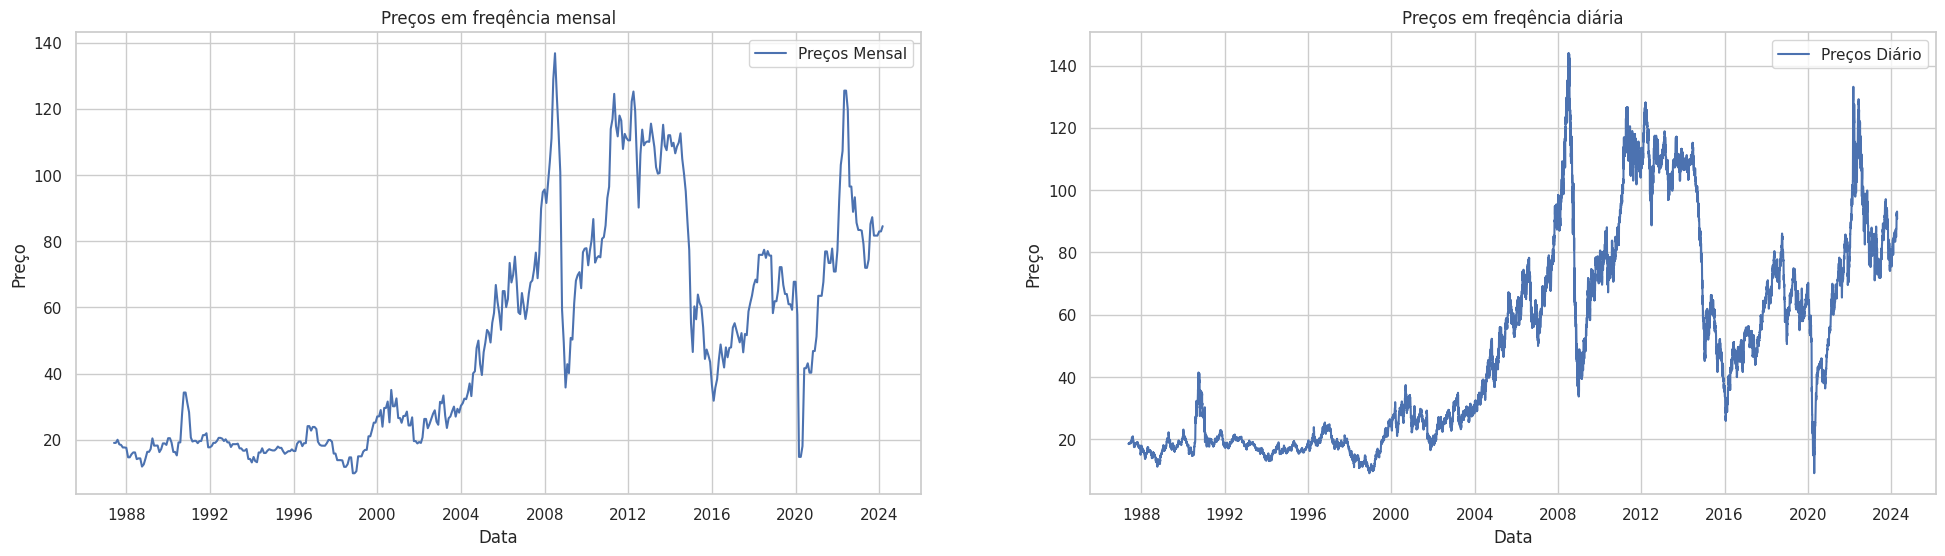

In [ ]:
#A primeira coisa que vamos fazer é comparar os gráficos de tendência diária e mensal para decidir como faremos a análise exploratória

df_mensal = df.asfreq('M').fillna(method='bfill')
df_diario = df.asfreq('D').fillna(method='bfill')

sns.set(style="whitegrid")

# Preparando o ambiente gráfico
plt.figure(figsize=(24, 6))

# 1 linha, 2 colunas, primeiro gráfico para frequência mensal
plt.subplot(1, 2, 1)
sns.lineplot(x=df_mensal.index, y=df_mensal['y'], label='Preços Mensal')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Preços em freqência mensal')
plt.legend()

# 1 linha, 2 colunas, segundo gráfico para frequência diária
plt.subplot(1, 2, 2)
sns.lineplot(x=df_diario.index, y=df_diario['y'], label='Preços Diário')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Preços em freqência diária')
plt.legend()

# Exibir os gráficos
plt.show()

Pode-se observar que o gráfico de tendência diária tem mais variabilidade que o de tendência mensal, portanto vamos utilizar a tendência diária para os modelos.

##### **Seasonal Decompose**

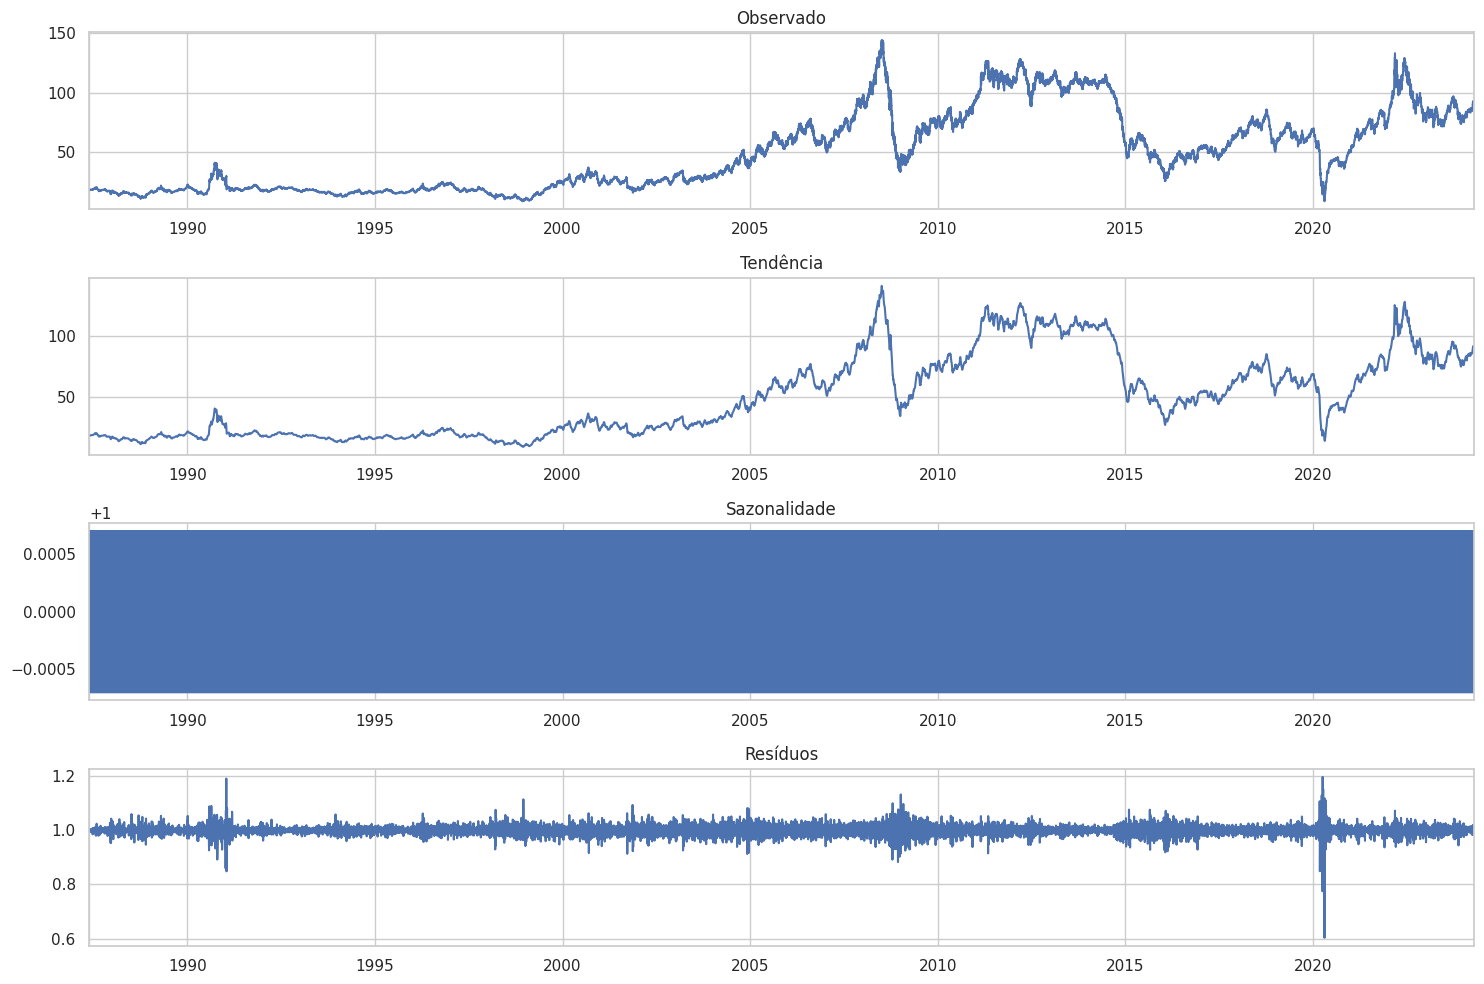

In [ ]:
#Decomposição dos dados

# A função seasonal_decompose meio que faz toda a decomposição dos dados para nós
resultados = seasonal_decompose(df_diario, model='multiplicative')

# Vamos criar subplots por que o legal é ver todos juntos
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))

resultados.observed.plot(ax=ax1, title='Observado', xlabel='')
resultados.trend.plot(ax=ax2, title='Tendência', xlabel='')
resultados.seasonal.plot(ax=ax3, title='Sazonalidade', xlabel='')
resultados.resid.plot(ax=ax4, title='Resíduos', xlabel='')

plt.tight_layout()
plt.show()

**Dados Originais:** O gráfico da série temporal original revela variações notáveis no preço do petróleo, influenciadas por diversos enentos externos.

**Gráfico de Tendência:** Este gráfico mostra uma visão mais suavizada das mudanças de longo prazo nos preços. Mas há ainda mudanças e flutuações.

**Gráfico Sazonal:** Apresenta flutuações periódicas e previsíveis que, no entanto, são pequenas em comparação com as variações totais observadas, indicando que a sazonalidade não é um fator predominante nos dados.

**Gráfico de Resíduos:** Mostra os elementos restantes após a remoção da tendência e sazonalidade. Os resíduos apresentam volatilidade e possivelmente contêm informações adicionais, sugerindo que há elementos aleatórios ou não capturados pelos outros componentes que poderiam ser explorados mais a fundo.

##### **Teste ADF**

##### **Base pura**

In [ ]:
# Configurar o estilo do Seaborn para os gráficos
sns.set(style="darkgrid")

# Você pode obter os valores da série temporal assim:
X = df_diario['y'].dropna().values

# Calcula a média móvel de 12 períodos
ma = df_diario.rolling(12).mean()

# Realizar o teste ADF com função definida anteriormente
teste_adf(X)

Teste ADF
Teste Estatístico: -1.989744955212182
P-Value: 0.29108760206831386
Valores críticos:
1%: -3.430836684239235
5%: -2.8617550915451226
10%: -2.566884488356167


Como o valor do teste estatístico de -2.014 não é menor que nenhum dos valores críticos e o p-valor é alto, isso sugere que a série temporal não é estacionária



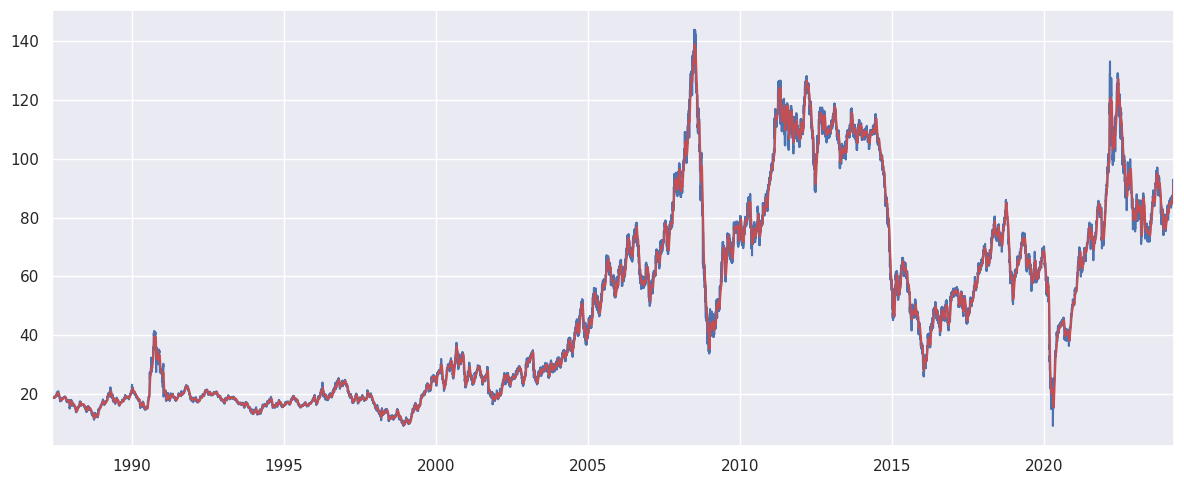

In [ ]:
#Plotar Gráficos com função definida anteriormente
plot_graficos(df_diario, ma)

A análise da série temporal revela variação significativa na média e amplitude ao longo do tempo, indicando não estacionariedade. Uma tendência geral de aumento nos preços é capturada, especialmente notável em 2008 e após 2010. Devido a essas flutuações e crescimento, será aplicada uma transformação logarítmica para estabilizar a variância e facilitar a modelagem estatística.

##### **Transformação Logarítmica**

Um método de transformação que visa tornar a base mais estacionária

In [ ]:
# Aplica a transformação logarítmica aos dados do DataFrame
df_log = np.log(df_diario)

# Calcula a média móvel de 12 períodos dos dados transformados
ma_log = df_log.rolling(12).mean()

X_log = df_log.y.values

# Realizar o teste ADF
teste_adf(X_log)

Teste ADF
Teste Estatístico: -1.8539285167851753
P-Value: 0.35403504407787967
Valores críticos:
1%: -3.4308365755997707
5%: -2.8617550435355223
10%: -2.5668844628010623


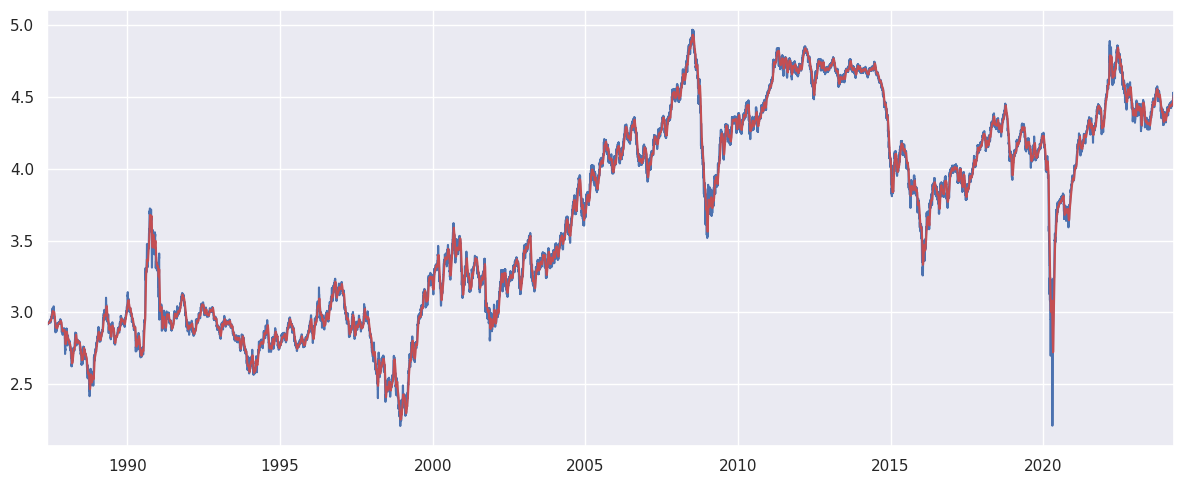

In [ ]:
#Plotar Gráficos
plot_graficos(df_log, ma_log)

Conforme observado, a base ainda não pode ser considerada estacionária

##### **Subtração da média móvel e da transformação logarítmica**

Como observamos dados não estacionários, vamos partir para  abordagem de subtrair a média móvel dos dados transformados via transformação logarítmica, um método conhecido por tornar os dados estacionários a ponto de podermos realizar a modelagem

In [ ]:
# Aplica a transformação logarítmica aos dados do DataFrame
df_log = np.log(df_diario.dropna())

# Calcula a média móvel de 12 períodos dos dados transformados
ma_log = df_log.rolling(12).mean()

# Subtrai a média móvel dos dados transformados
df_s = (df_log - ma_log).dropna()

# Calcula a média móvel da série resultante
ma_s = df_s.rolling(12).mean()

# Calcula o desvio padrão móvel da série resultante
std = df_s.rolling(12).std()

X_s = df_s.y.values

# Realizar o teste ADF
teste_adf(X_s)

Teste ADF
Teste Estatístico: -16.188415659057874
P-Value: 4.195286974208612e-29
Valores críticos:
1%: -3.430836974181787
5%: -2.861755219675588
10%: -2.5668845565589327


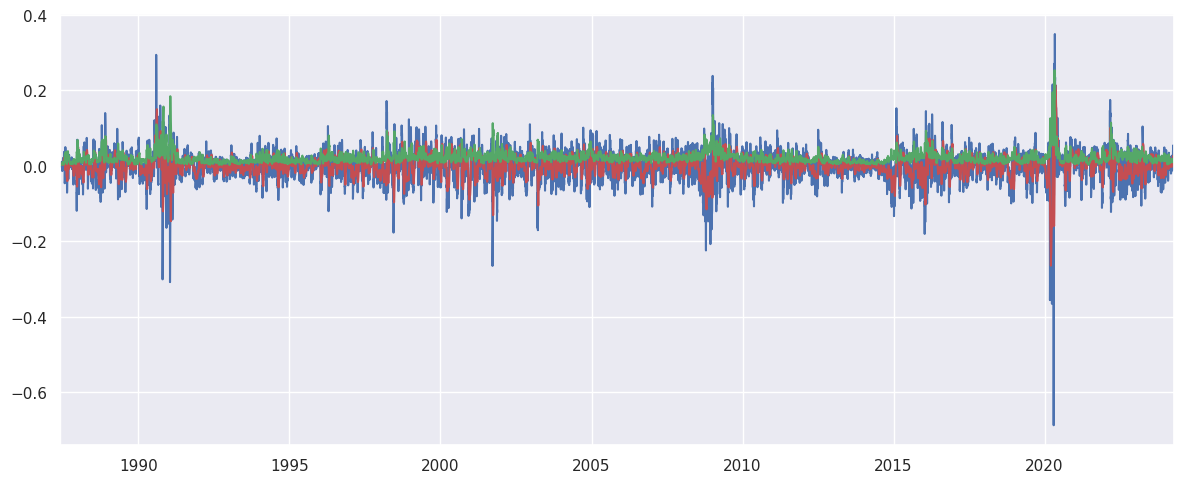

In [ ]:
#Plotar Gráficos
plot_graficos(df_s, ma_s, std)


A análise da série temporal ajustada mostra a média móvel oscilando em torno de zero e um desvio padrão constante, indicando potencial estacionariedade. O teste ADF reforça essa ideia, com um teste estatístico significativamente abaixo do valor crítico e um valor-p quase nulo, confirmando a ausência de raiz unitária e validando a estacionariedade da série. Isso permite avançar com a modelagem de previsão em uma base mais estável e consistente.

### **Modeling**

##### **Funções úteis**

In [ ]:
# Definindo a função WMAPE
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

# Definindo a função MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Criando uma função que calcula e imprime WMAPE e MAPE
def metricas_modelo(y_true, y_pred):
    wmape_value = wmape(y_true, y_pred)
    mape_value = mape(y_true, y_pred)
    return f"WMAPE: {wmape_value:.2%}", f"MAPE: {mape_value:.2f}%", f"Acurácia: {(1-wmape_value)*100:.2f}%"

def treino_prophet(train, test):
    """
    Treina um modelo Prophet com os dados de treino e faz previsões no conjunto de teste.

    Args:
    train (pandas.DataFrame): DataFrame de treino contendo duas colunas 'ds' e 'y'.
    test (pandas.DataFrame): DataFrame de teste contendo a coluna 'ds'.

    Returns:
    pandas.DataFrame: DataFrame contendo as datas 'ds', os valores reais 'y' e as previsões 'yhat'.
    """
    # Criando o modelo Prophet
    modelo = Prophet(daily_seasonality=True)

    # Calculando o número de períodos a prever
    h = test.index.nunique()

    # Treinando o modelo
    train = train.reset_index()
    modelo.fit(train)

    # Criando DataFrame para previsões futuras
    dataframefuturo = modelo.make_future_dataframe(periods=h, freq='D')

    # Fazendo previsões
    predict_df = modelo.predict(dataframefuturo)

    # Combinando previsões com os dados de teste
    predict_df = predict_df[['ds', 'yhat']].merge(test, on='ds', how='left').dropna()

    print(metricas_modelo(predict_df['y'], predict_df['yhat']))

    return predict_df

##### **Separação da Base**

In [ ]:
#Base 1
df_diario = df_diario.copy()
df_diario = df_diario[df_diario.index >= pd.Timestamp('2004-01-01')]

#Base 2
df_log = np.log(df_diario)

#Base 3
ma_log = df_log.rolling(12).mean()
df_s = (df_log - ma_log).dropna()

In [ ]:
# A primeira etapa do processo de modelagem será separar os dataframes em treino e teste

train_modeling, test_modeling = train_test_split(df_diario, test_size=0.2, shuffle=False)
train_log, test_log = train_test_split(df_log, test_size=0.2, shuffle=False)
train_s, test_s = train_test_split(df_s, test_size=0.2, shuffle=False)

##### **Treino dos modelos**

In [ ]:
predict_prophet_real = treino_prophet(train_modeling, test_modeling)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7lede60/y1gxc71u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7lede60/rp2cxraj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74405', 'data', 'file=/tmp/tmpg7lede60/y1gxc71u.json', 'init=/tmp/tmpg7lede60/rp2cxraj.json', 'output', 'file=/tmp/tmpg7lede60/prophet_modelokhmq29i/prophet_model-20240421152335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:23:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:23:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


('WMAPE: 19.56%', 'MAPE: 29.54%', 'Acurácia: 80.44%')


In [ ]:
predict_prophet_log = treino_prophet(train_log, test_log)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7lede60/i2yxqrb0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7lede60/mapgskhq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96856', 'data', 'file=/tmp/tmpg7lede60/i2yxqrb0.json', 'init=/tmp/tmpg7lede60/mapgskhq.json', 'output', 'file=/tmp/tmpg7lede60/prophet_modeldjaxenf0/prophet_model-20240421152347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:23:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:23:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


('WMAPE: 5.36%', 'MAPE: 5.94%', 'Acurácia: 94.64%')


In [ ]:
predict_prophet_media = treino_prophet(train_s, test_s)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7lede60/corkvcbm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7lede60/ypenikzt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39639', 'data', 'file=/tmp/tmpg7lede60/corkvcbm.json', 'init=/tmp/tmpg7lede60/ypenikzt.json', 'output', 'file=/tmp/tmpg7lede60/prophet_model7ku78i8h/prophet_model-20240421152355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:23:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:23:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


('WMAPE: 134.63%', 'MAPE: 1005.21%', 'Acurácia: -34.63%')


Quando temos um modelo que performa melhor com a transformação logarítmica, temos que levar em conta que quando fizermos  transformação contrária ele perderá perfomance e não terá a acurácia real dele, portanto, 80% é uma acurácia moderada, e o modelo com dados reais (sem transformações) será o que escolherei


##### **Decomposição do modelo escolhido e análise dos resultados**

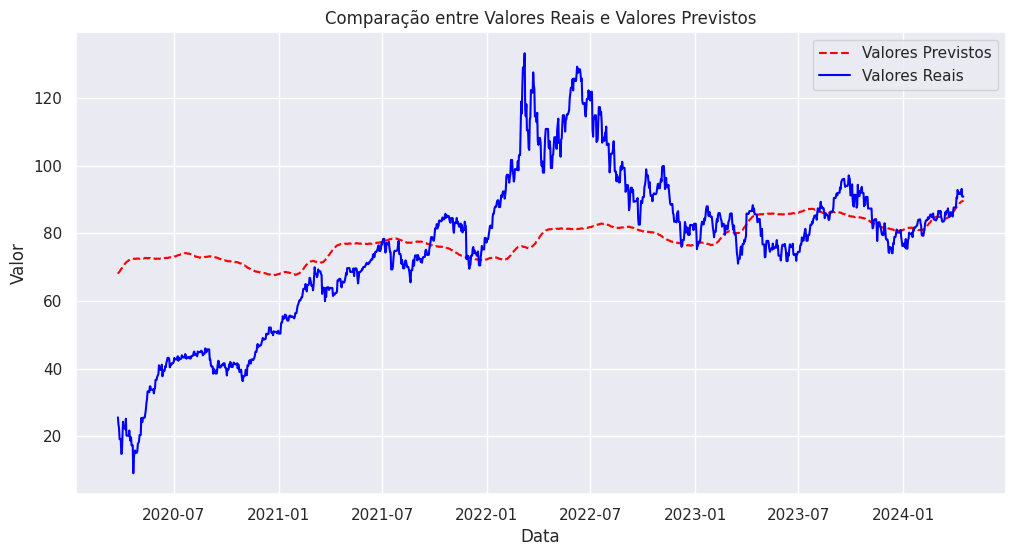

In [ ]:
plt.figure(figsize=(12, 6))

# Plotando a linha dos valores previstos
plt.plot(predict_prophet_real['ds'], predict_prophet_real['yhat'], label='Valores Previstos', color='red', linestyle='--')

# Plotando a linha dos valores reais
plt.plot(predict_prophet_real['ds'], predict_prophet_real['y'], label='Valores Reais', color='blue')

# Adicionando título e rótulos
plt.title('Comparação entre Valores Reais e Valores Previstos')
plt.xlabel('Data')
plt.ylabel('Valor')

# Mostrando a legenda

plt.legend()

# Exibindo o gráfico
plt.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7lede60/_ymfte9j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7lede60/cujj9tu1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38883', 'data', 'file=/tmp/tmpg7lede60/_ymfte9j.json', 'init=/tmp/tmpg7lede60/cujj9tu1.json', 'output', 'file=/tmp/tmpg7lede60/prophet_modelgg3zbs1c/prophet_model-20240421152359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:23:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:24:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


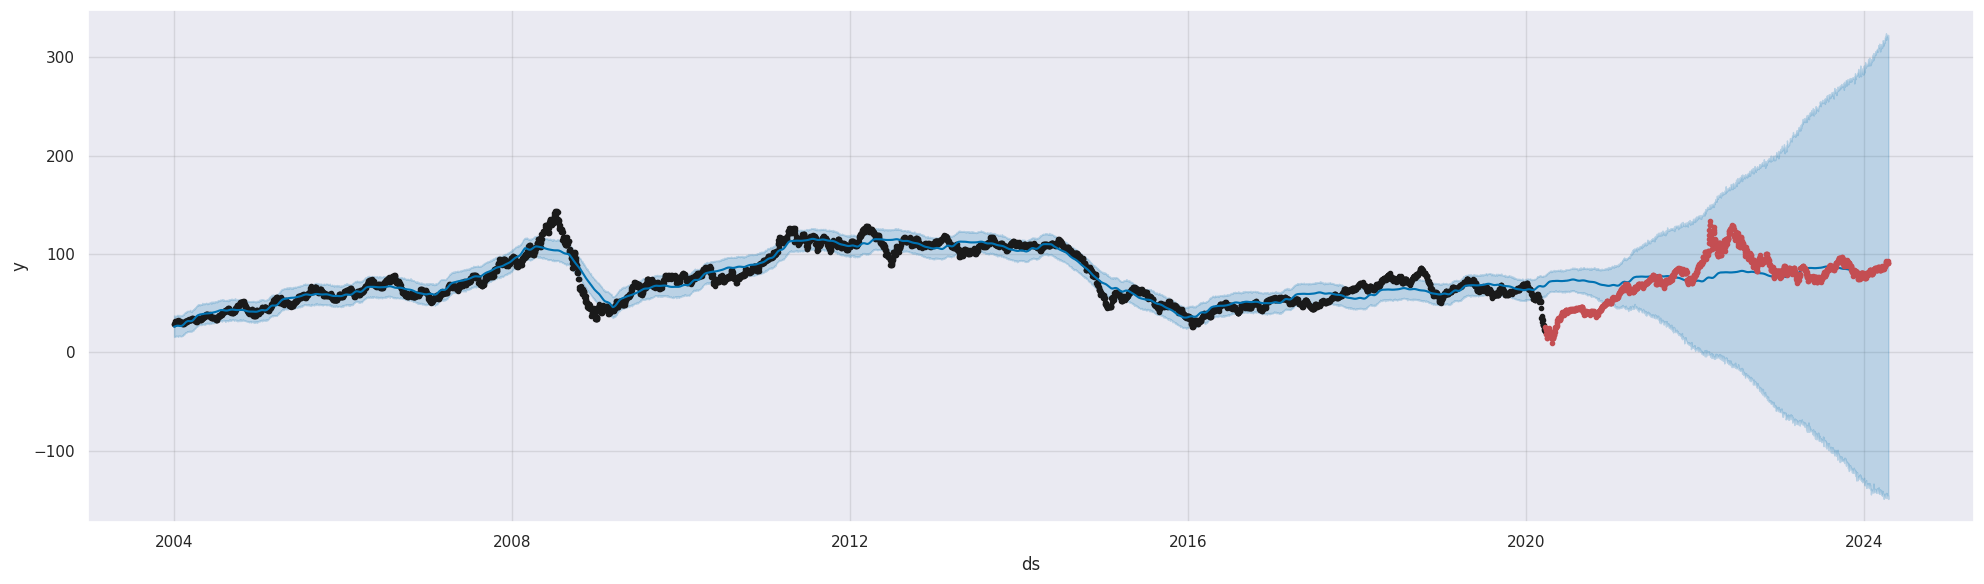

In [ ]:
modelo = Prophet(daily_seasonality=True)

# Calculando o número de períodos a prever
h = test_modeling.index.nunique()

# Treinando o modelo
train = train_modeling.reset_index()
test = test_modeling.reset_index()
modelo.fit(train)

# Criando DataFrame para previsões futuras
dataframefuturo = modelo.make_future_dataframe(periods=h, freq='D')

# Fazendo previsões
predict_df = modelo.predict(dataframefuturo)

modelo.plot(predict_df, figsize=(20,6));
plt.plot(test['ds'], test['y'], '.r')

##### **Salvando o Modelo**

In [ ]:
import pickle

# Suponha que 'model' é seu modelo Prophet treinado
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(modelo, f)

### **Plano de Deploy**

##### **Funções de Deploy**

In [ ]:
# Carregar o modelo
with open('prophet_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [ ]:
def load_data():
  url = "http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view"
  response = requests.get(url)
  dfs = pd.read_html(response.text, attrs={'id': 'grd_DXMainTable'})
  if len(dfs) > 0:
      df = dfs[0]
      df.columns = ['Data', 'Preco']
      df.to_csv('preco_petroleo_brent_atualizado.csv', index=False, encoding='utf-8')
      df = pd.read_csv('preco_petroleo_brent_atualizado.csv')
  else:
      print("Nenhuma tabela encontrada.")

  df = df.drop(0)
  df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
  df = df.reset_index(drop=True).sort_values(by="Data", ascending=False)
  df['Preco'] = df['Preco'].astype(int) / 100
  df = df.rename(columns= {'Data':'ds', 'Preco': 'y'})
  df = df[['ds', 'y']]
  df.set_index('ds', inplace=True)

  df_diario = df.asfreq('D').fillna(method='bfill')
  df_diario = df_diario.reset_index()

  return df_diario

In [ ]:
def prever_modelo(df, periodo):

    start_date = datetime.now()
    future_dates = pd.date_range(start=start_date, periods=periodo, freq='D')
    future_df = pd.DataFrame(future_dates, columns=['ds'])
    forecast = loaded_model.predict(future_df)
    previsao = forecast[['ds', 'yhat']]

    return previsao

def construcao_df_final(df, previsao):

    df_final = pd.merge(df, previsao, on='ds', how='outer')
    df_final['tipo_dado'] = 'Dado Real'
    df_final.loc[df_final['y'].isnull(), 'tipo_dado'] = 'Dado Predito'
    df_final['y'].fillna(df_final['yhat'], inplace=True)
    df_final['y'] = df_final['y'].round(2).astype(float)
    df_final = df_final[['ds', 'y', 'tipo_dado']].rename(columns={'ds': 'data', 'y': 'valor'})

    return df_final

In [ ]:
def generate_plot_modelo_ml(df):
    # Criando dados fictícios para o exemplo
    df_modelo = df[df['data'] >= pd.to_datetime('2023-12-01')]

    # data específica para mudar a cor
    data_limite = df_modelo[df_modelo['tipo_dado'] == 'Dado Real']['data'].max()

    # Criar o gráfico de linha usando Seaborn
    plt.figure(figsize=(10, 6))

    # Linha antes da data limite
    sns.lineplot(x='data', y='valor', data=df_modelo[df_modelo['data'] <= data_limite], color='#3071f2',
                 label='Valor Real')

    # Linha após a data limite
    sns.lineplot(x='data', y='valor', data=df_modelo[df_modelo['data'] >= data_limite], color='#f2a20c',
                 label='Valor Predito')

    # Conectar visualmente as duas partes
    plt.axvline(x=data_limite, color='gray', linestyle='--', linewidth=2,
                label='Data de Transição: {}'.format(data_limite.strftime('%d-%m-%Y')))

    # Adicionar rótulos e título
    plt.title('Visualização Dados Reais x Dados Preditos', color="white", fontsize=16)
    plt.xlabel('Data', color="white", fontsize=14)
    plt.ylabel('Preço (USD)', color="white", fontsize=14)
    plt.tick_params(axis='x', labelcolor='white')
    plt.tick_params(axis='y', labelcolor='white')
    plt.xticks(rotation=45)

    # Adicionar legenda
    legend = plt.legend()
    legend.get_frame().set_facecolor('#32363e')

    for texto in legend.get_texts():
        texto.set_color('white')

    # Exibindo os gráficos
    plt.show()

##### **Apicando o Modelo**

In [ ]:
df = load_data()

In [ ]:
previsao = prever_modelo(df, 5)

In [ ]:
df_final = construcao_df_final(df, previsao)

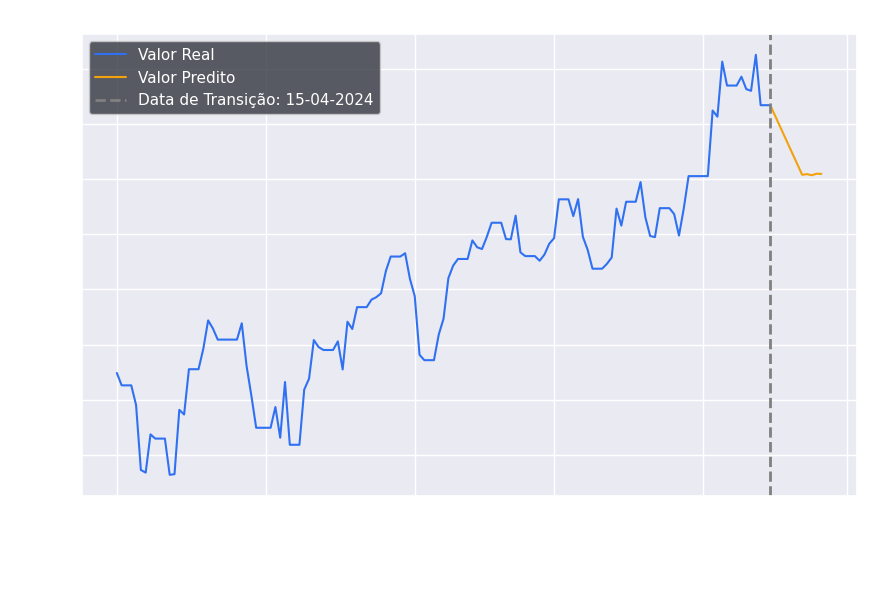

In [ ]:
generate_plot_modelo_ml(df_final)

O notebook usado como base para o streamlit foi esse, claro que algumas funçoes foram mudadas para a adaptação ao novo ambiente, além de que, na hora, tive várias outras ideias e fiz tudo lá mesmo, mas com ele conseguimos ter uma ideia de como foi o processo de decisão e escolha do modelo.